!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

In [1]:
import os
import torch
import numpy as np
import torch.nn as nn
from torch import optim
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
batch_size = 256

In [4]:
with open('input_milkshake.txt', 'r', encoding='utf-8') as f:
    text = f.read()

In [5]:
print("length of dataset in characters: ", len(text))

length of dataset in characters:  1115394


In [6]:
print(text[:1000])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor citizens, the patricians good.
What authority surfeits on would relieve us: if they
would yield us but the superfluity, while it were
wholesome, we might guess they relieved us humanely;
but they think we are too dear: the leanness that
afflicts us, the object of our misery, is as an
inventory to particularise their abundance; our
sufferance is a gain to them Let us revenge this with
our pikes, ere we become rakes: for the gods know I
speak this in hunger for bread, not in thirst for revenge.



In [7]:
# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)
print(''.join(chars))
print(vocab_size)


 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
65


In [8]:
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

print(encode("hello"))
print(decode(encode("hello")))

[46, 43, 50, 50, 53]
hello


In [9]:
data = torch.tensor(encode(text))
n = int(0.8*len(data))
train_data = data[:n]
val_data = data[n:]


In [10]:
class TinyDataSet(Dataset):
    def __init__(self, data, context_size = 8):
        self.x = []
        self.y = []
        context_blocks_number = data.shape[0] // context_size
        for i in range(context_blocks_number):
            left = i * context_size
            right = left + context_size
            if right >= data.shape[0]:
                break
            self.x.append(data[left : right])
            self.y.append(data[left+1:right+1])
        self.x = torch.stack(self.x)
        self.y = torch.stack(self.y)
    def __getitem__(self, index):
        return self.x[index], self.y[index]
    def __len__(self):
        return self.x.shape[0]
        

In [11]:

train_dataset = TinyDataSet(train_data)
val_dataset = TinyDataSet(val_data)
print(len(train_dataset), len(val_dataset))

111539 27884


In [12]:
train_loader = DataLoader(dataset = train_dataset, 
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=6, 
                          )
val_loader = DataLoader(dataset = val_dataset, 
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=6,
                          )

In [13]:
class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, d_model, dropout):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d_model, 4 * d_model),
            nn.ReLU(),
            nn.Linear(4 * d_model, d_model),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)
    
class AttentionHead(nn.Module):
    def __init__(self, d_model, head_size, block_size):
        super().__init__()
        self.Q = nn.Linear(d_model, head_size, bias = False)
        self.K = nn.Linear(d_model, head_size, bias = False)
        self.V = nn.Linear(d_model, head_size, bias = False)
        self.register_buffer('trill', torch.tril(torch.ones(block_size, block_size))) # <--- tell pytorch that this is not a parameter
        
    def forward (self, x):
        b, t, c = x.shape
        query = self.Q(x)
        key = self.K(x)
        value = self.V(x)
        
        wei = query @ key.transpose(-2, -1)
        wei = wei.masked_fill(self.trill[:t, :t] == 0, float('-inf'))
        wei = wei / query.shape[2]**-0.5
        wei = F.softmax(wei, dim = -1)
        
        return wei @ value
    
class TransformerDecoderLayer(nn.Module):
    def __init__(self, d_model, nheads, block_size, dropout):
        super().__init__()
        self.partition_size = d_model // nheads
        if d_model % nheads != 0:
            raise TypeError
        self.heads = nn.ModuleList([AttentionHead(d_model = self.partition_size,
                                                  head_size= d_model,
                                                  block_size = block_size) for _ in range(nheads)])
        self.proj = nn.Linear(d_model * nheads, d_model)
        self.dropout = nn.Dropout(p = dropout)
        
    def forward(self, x):
        left  = lambda idx: self.partition_size * idx
        right = lambda idx: self.partition_size * idx + self.partition_size
        heads_out = [self.heads[i](x[:, :, left(i): right(i)]) for i in range(len(self.heads))]
        out = torch.cat(heads_out, dim = -1)
        out = self.dropout(self.proj(out))
        return out


class TransformerBlock(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, d_model, nheads, block_size, dropout):
        # d_model: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        self.sa = TransformerDecoderLayer(d_model, nheads, block_size, dropout)
        self.ffwd = FeedFoward(d_model, dropout)
        self.ln1 = nn.LayerNorm(d_model)
        self.ln2 = nn.LayerNorm(d_model)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

class TransformerDecoder(nn.Module):
    def __init__(self, d_model, nheads, nlayers, block_size, dropout):
        super().__init__()
        trans_blocks = [TransformerBlock(d_model, nheads, block_size, dropout) for _ in range(nlayers)]
        self.trans_dec = nn.Sequential(*trans_blocks)
    def forward(self, x):
        return self.trans_dec(x)

class TinyGPT(nn.Module):
    def __init__(self, vocab_size, d_model, block_size, nheads, dropout):
        super().__init__()
        self.embs = nn.Embedding(vocab_size, d_model)
        self.position_embs = nn.Embedding(block_size, d_model)
        self.block = TransformerDecoder(d_model=d_model,
                                            nheads = nheads,
                                            nlayers=2,
                                            block_size= block_size,
                                            dropout=dropout)
        self.linear = nn.Linear(d_model, vocab_size)
        self.softmax = nn.Softmax(dim = 1)
        
    def forward(self, x):
        B, T = x.shape
        x = self.embs(x) + self.position_embs(torch.arange(T, device=device))
        x = self.block(x)
        logits = self.linear(x)
        B, T, C = logits.shape
        logits = logits.view(B*T, C)
        return logits
    
    def predict(self, idx, max_seq_len, block_size):
        for _ in range(max_seq_len):
            idx_cond = idx[:, -block_size:]
            logits = self(idx_cond)
            logits= logits[-1]
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1).unsqueeze(dim = 1)
            idx = torch.cat((idx, idx_next), dim = 1)
        return idx

In [14]:
model = TinyGPT(vocab_size = vocab_size,
                d_model = 32, 
                block_size=8, 
                nheads = 2,
                dropout = 0.1).to(device=device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr = 3e-4)
epochs = 200
train_loss_per_epoch = np.zeros(epochs)
val_loss_per_epoch = np.zeros(epochs)
for epoch in range(epochs):
    train_losses = []
    val_losses = []
    model.train()
    for x, y in train_loader:
        y = y.view(-1).to(device)
        preds = model(x.to(device))
        loss = loss_fn(preds, y)
        train_losses.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    model.eval()
    with torch.no_grad():
        for x, y in val_loader:
            y = y.view(-1).to(device)
            preds = model(x.to(device))
            loss = loss_fn(preds, y)
            val_losses.append(loss.item())
            
    avg_train_loss = sum(train_losses) / len(train_losses)
    avg_val_loss = sum(val_losses) / len(val_losses)
    train_loss_per_epoch[epoch] = avg_train_loss
    val_loss_per_epoch[epoch] = avg_val_loss
    if epoch % 10 == 0:
        print(f"Train loss: {avg_train_loss}; Validation loss: {avg_val_loss}")


Train loss: 3.087154101887974; Validation loss: 2.6303983478371156
Train loss: 2.1915290104139835; Validation loss: 2.1842794112109263
Train loss: 2.1042288804272995; Validation loss: 2.114712721710905
Train loss: 2.0543079433638023; Validation loss: 2.0836012100954666
Train loss: 2.0227165872897577; Validation loss: 2.06684476738676
Train loss: 2.001569257416856; Validation loss: 2.0538050887781547
Train loss: 1.9851034805862182; Validation loss: 2.047817483954473
Train loss: 1.9700597565655316; Validation loss: 2.039415151701061
Train loss: 1.959440878498445; Validation loss: 2.038612268386631
Train loss: 1.949997566708731; Validation loss: 2.0302749686284898
Train loss: 1.9417938562708164; Validation loss: 2.02473852393824
Train loss: 1.9347592830111127; Validation loss: 2.020073122934464
Train loss: 1.9286910968089321; Validation loss: 2.015848069015993
Train loss: 1.9245946697138865; Validation loss: 2.0129090438195325
Train loss: 1.9199576744245828; Validation loss: 2.01245384260

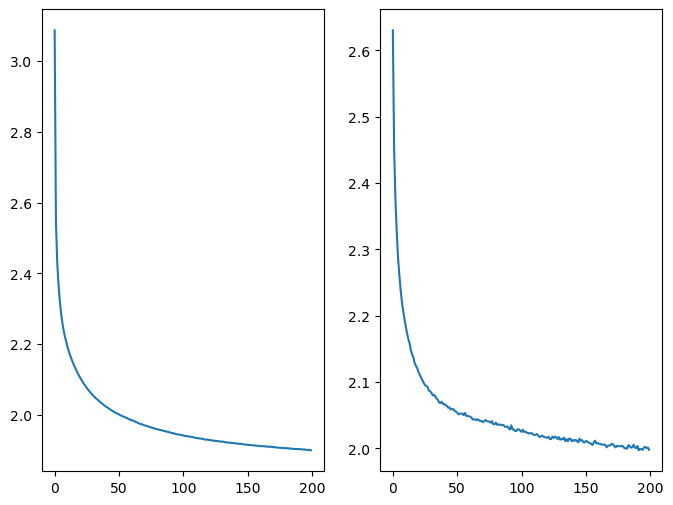

In [15]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize = (8,6))
ax[0].plot(range(0, epochs), train_loss_per_epoch)
ax[1].plot(range(0, epochs), val_loss_per_epoch)

In [16]:
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(model.predict(context, max_seq_len=2000, block_size=8)[0].tolist()))


Now pastring sly as thee broke should,
The not; and thall'd fits. And but and wour lanner pristel lordthest this lead's brart, which morrive ariad to need-in what this to this grave inte Firsels you doned,
Of and Edwast only bechight olf,
Thall love shall thou heir go.

DUKE OF YORK:
Go o' but my
Welt dredengs trelse, from and meastly!
Am, Rerve us seld amuckly,
Your are never
'Zupon me struove's neart
When man am heave bether lick hy sweeet gontirl dius: ower: will a best who as as beausestion troon.
Her:
Naaten you arish
COMINIUS:
Yy vile, with pror thean of thou sleem them iman this the in mands: noly
ress Catesueits give soman'st our shall might! LordUS:
And.

POMPSO til as regn and with oyou mare live, at and thou but All home,
Whenes-douch your me sild snembly;
Your is shommence bedgenly theath unfurn yet I meright,
Mast them his prostion the somore words of.

QUEEN EDWARD IV:
Hein ever
The vereir corenged polved your morringmer know'd news to have would and sten is, thrumpilest